```c
    /\_/\           ___
   = o_o =_______    \ \  -my_3pt_king.ipynb-
    __^      __(  \.__) )
(@)<_____>__(_____)____/
```

~ analysing stephen curry

### installation

In [2]:
pip install nba-api pandas numpy matplotlib seaborn scikit-learn xgboost streamlit

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### fetching curry's data (nba_api)

In [3]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
import pandas as pd, time

def fetch_curry_seasons(seasons, pause=1):
    """
    fetches Curry's shot chart data for specified seasons
    """
    curry = players.find_players_by_full_name("Stephen Curry")[0]
    all_df = []

    # Loop through each season and fetch data
    for season in seasons:
        print(f"Fetching {season}…")
        df = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=curry['id'],
            season_nullable=season,
            season_type_all_star='Regular Season',
            context_measure_simple='FGA'
        ).get_data_frames()[0]
        df['season'] = season
        all_df.append(df)
        time.sleep(pause)

    # Concatenate all DataFrames into one
    return pd.concat(all_df, ignore_index=True)

seasons = [
    '2009-10', '2010-11', '2011-12', '2012-13', '2013-14',
    '2014-15', '2015-16', '2016-17', '2017-18', '2018-19',
    '2019-20', '2020-21', '2021-22', '2022-23', '2023-24',
    '2024-25'
]
df_raw = fetch_curry_seasons(seasons)

# Save
df_raw.to_csv('../data/raw/curry_2009to25.csv', index=False)

/Users/puolsky/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Fetching 2009-10…
Fetching 2010-11…
Fetching 2011-12…
Fetching 2012-13…
Fetching 2013-14…
Fetching 2014-15…
Fetching 2015-16…
Fetching 2016-17…
Fetching 2017-18…
Fetching 2018-19…
Fetching 2019-20…
Fetching 2020-21…
Fetching 2021-22…
Fetching 2022-23…
Fetching 2023-24…
Fetching 2024-25…


### cleaning + feature engineering

In [4]:
import pandas as pd, numpy as np

# Load raw multi‑season
df = pd.read_csv('../data/raw/curry_2009to25.csv')

# Standardize colnames
df.columns = df.columns.str.lower()

# Select relevant cols
keep = [
    'game_id','game_date','season','period','minutes_remaining','seconds_remaining',
    'shot_distance','loc_x','loc_y','shot_type','shot_zone_basic',
    'shot_zone_area','shot_zone_range','shot_made_flag'
]
df = df[keep]

# Time remaining (s)
df['time_remaining'] = df.minutes_remaining*60 + df.seconds_remaining

# Shot angle (deg)
df['shot_angle'] = np.degrees(np.arctan2(df.loc_x, df.loc_y))

# Flag 3PT
df['is_3pt'] = df.shot_distance >= 23

# Early vs Late game
df['game_segment'] = np.where(df.period<=2, 'early', 'late')

# Clutch (<10s)
df['is_clutch'] = df.time_remaining < 10

# Save processed
df.to_csv('../data/processed/cleaned_curry_2009to25.csv', index=False)

### shot chart

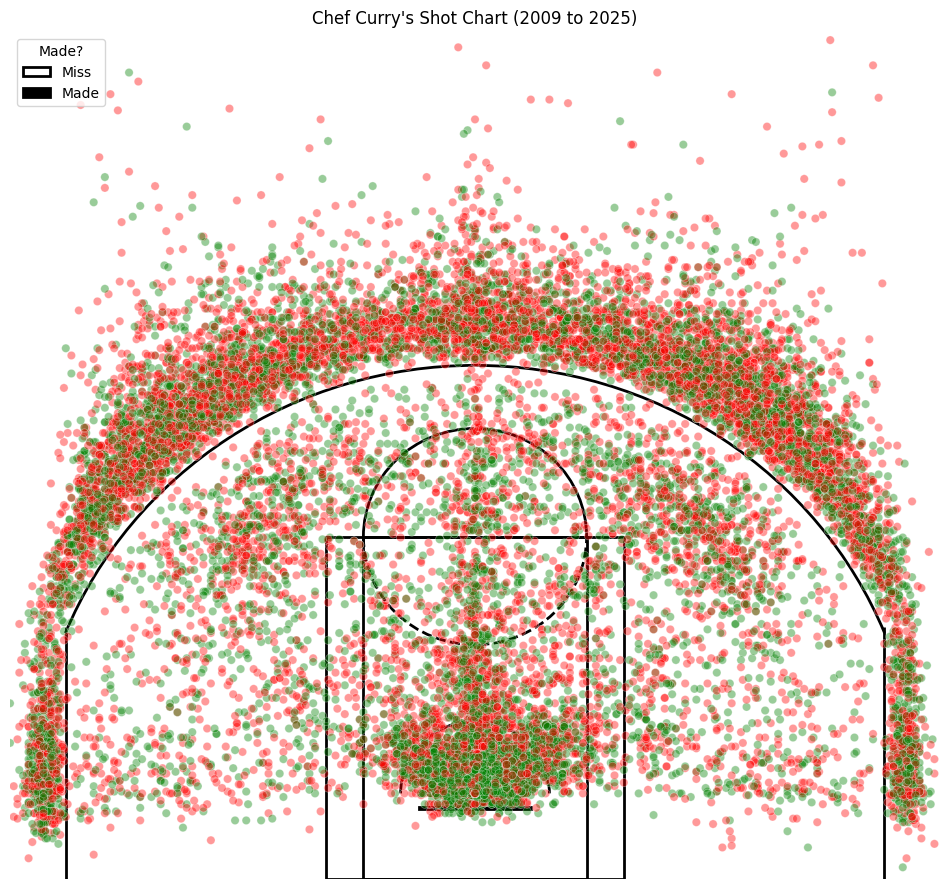

In [5]:
import matplotlib.pyplot as plt, seaborn as sns
from court import draw_half_court

df = pd.read_csv('../data/processed/cleaned_curry_2009to25.csv')

plt.figure(figsize=(12,11))
ax = plt.gca()
draw_half_court(ax)

sns.scatterplot(
    data=df, x='loc_x', y='loc_y',
    hue='shot_made_flag',
    palette={1:'green', 0:'red'},
    alpha=0.4, ax=ax
)
plt.title("Chef Curry's Shot Chart (2009 to 2025)")
plt.legend(title='Made?', labels=['Miss','Made'])
plt.show()


### hotzone% heatmap ykwims

/var/folders/8_/fn7p0lxn2bd0qjm9xyy33lwm0000gn/T/ipykernel_54666/1995958640.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grid = df.groupby(pd.cut(df.shot_distance, bins=20)).apply(


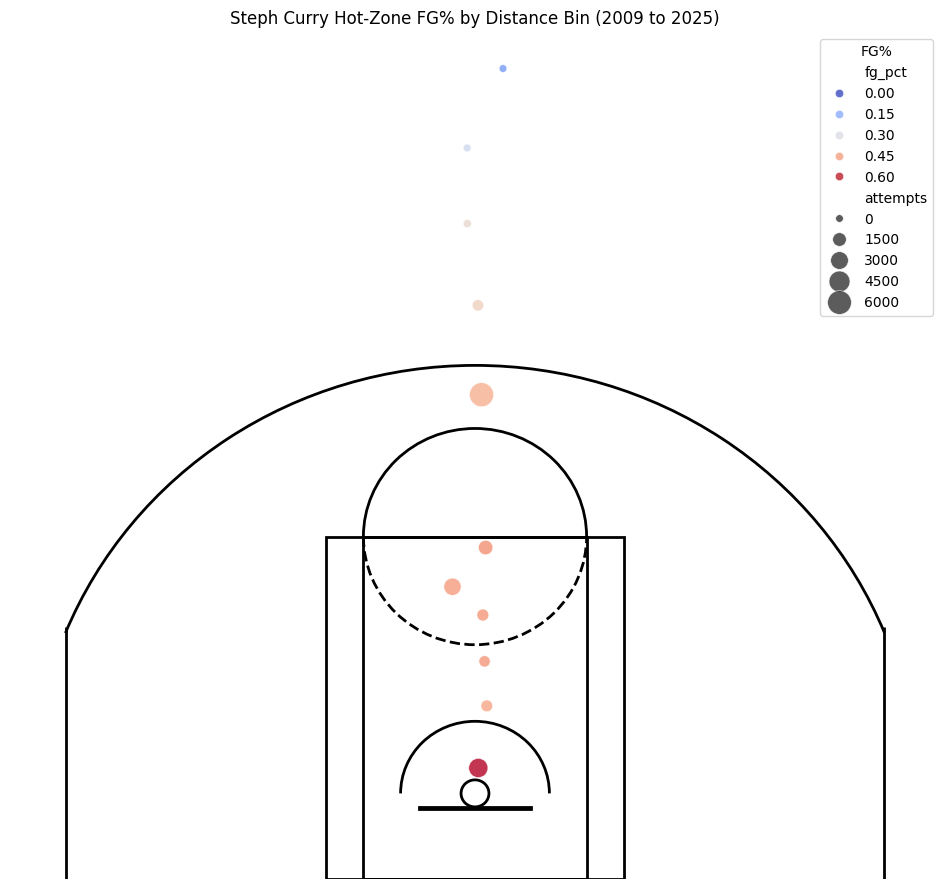

In [6]:
# aggregate by grid
grid = df.groupby(pd.cut(df.shot_distance, bins=20)).apply(
    lambda g: pd.Series({
        'x': g.loc_x.mean(), 'y': g.loc_y.mean(),
        'fg_pct': g.shot_made_flag.mean(),
        'attempts': len(g)
    })
).reset_index(drop=True)

plt.figure(figsize=(12,11))
ax = plt.gca()
draw_half_court(ax)

# size ~ attempts, color ~ fg_pct
sns.scatterplot(
    data=grid, x='x', y='y',
    size='attempts', sizes=(30,300),
    hue='fg_pct', palette='coolwarm',
    alpha=0.8, ax=ax, legend='brief'
)
plt.title("Steph Curry Hot-Zone FG% by Distance Bin (2009 to 2025)")
plt.legend(title='FG%')
plt.show()


### modelling

#### random forest modeling

result: slightly better than guessing but still q underwhelming, esp for predicting made shots (label = 1)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Load processed
df = pd.read_csv('../data/processed/cleaned_curry_2009to25.csv')

# Features & target
X = df[['shot_distance','shot_angle','time_remaining','is_3pt','is_clutch']]
y = df.shot_made_flag

# Train/test split - i think 80/20 is fine here probably
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train RF
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluate by classification report and confusion matrix
print(classification_report(y_test, rf.predict(X_test)))
print("="*25)
print("Confusion Matrix:\n", confusion_matrix(y_test, rf.predict(X_test)))

# Feature importances woohoo
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("="*25)
print("Feature Importances:\n", imp)
print("="*25)


              precision    recall  f1-score   support

           0       0.57      0.60      0.58      1951
           1       0.52      0.49      0.50      1720

    accuracy                           0.55      3671
   macro avg       0.54      0.54      0.54      3671
weighted avg       0.55      0.55      0.55      3671

Confusion Matrix:
 [[1165  786]
 [ 879  841]]
Feature Importances:
 shot_angle        0.457223
time_remaining    0.430292
shot_distance     0.104665
is_3pt            0.005328
is_clutch         0.002493
dtype: float64


#### a better rf model

result: still better than random, but not strong yet, XGBoost has stabilized things ig

In [8]:
# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder

# === 2. Load and prepare data ===
df = pd.read_csv('../data/processed/cleaned_curry_2009to25.csv')

# Combine categorical zones
df['zone_combo'] = df['shot_zone_basic'] + ' - ' + df['shot_zone_area']

# Select features
features = ['shot_distance', 'shot_angle', 'time_remaining', 'period', 'zone_combo']
target = 'shot_made_flag'

X_raw = df[features]
y = df[target]

# === 3. One-hot encode categorical ===
categorical_cols = ['period', 'zone_combo']
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X_raw[categorical_cols])
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine numerical + encoded
X_final = pd.concat([X_raw.drop(columns=categorical_cols).reset_index(drop=True),
                     encoded_df.reset_index(drop=True)], axis=1)

# === 4. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# === 5. Train XGBoost ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.2)
xgb.fit(X_train, y_train)

# === 6. Evaluation ===
y_pred = xgb.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === 7. Feature Importances ===
importances = pd.Series(xgb.feature_importances_, index=X_final.columns)
print("\n=== Top 10 Feature Importances ===")
print(importances.sort_values(ascending=False).head(10))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.54      0.55      1951
           1       0.50      0.54      0.52      1720

    accuracy                           0.54      3671
   macro avg       0.54      0.54      0.54      3671
weighted avg       0.54      0.54      0.54      3671

=== Confusion Matrix ===
[[1047  904]
 [ 798  922]]

=== Top 10 Feature Importances ===
shot_distance                                           0.075046
zone_combo_Mid-Range - Center(C)                        0.066079
zone_combo_Mid-Range - Right Side Center(RC)            0.059167
period_4                                                0.058300
zone_combo_Mid-Range - Left Side Center(LC)             0.057991
time_remaining                                          0.051147
zone_combo_In The Paint (Non-RA) - Center(C)            0.050509
period_2                                                0.049085
shot_angle                         

/Users/puolsky/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [16:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### segment analysis

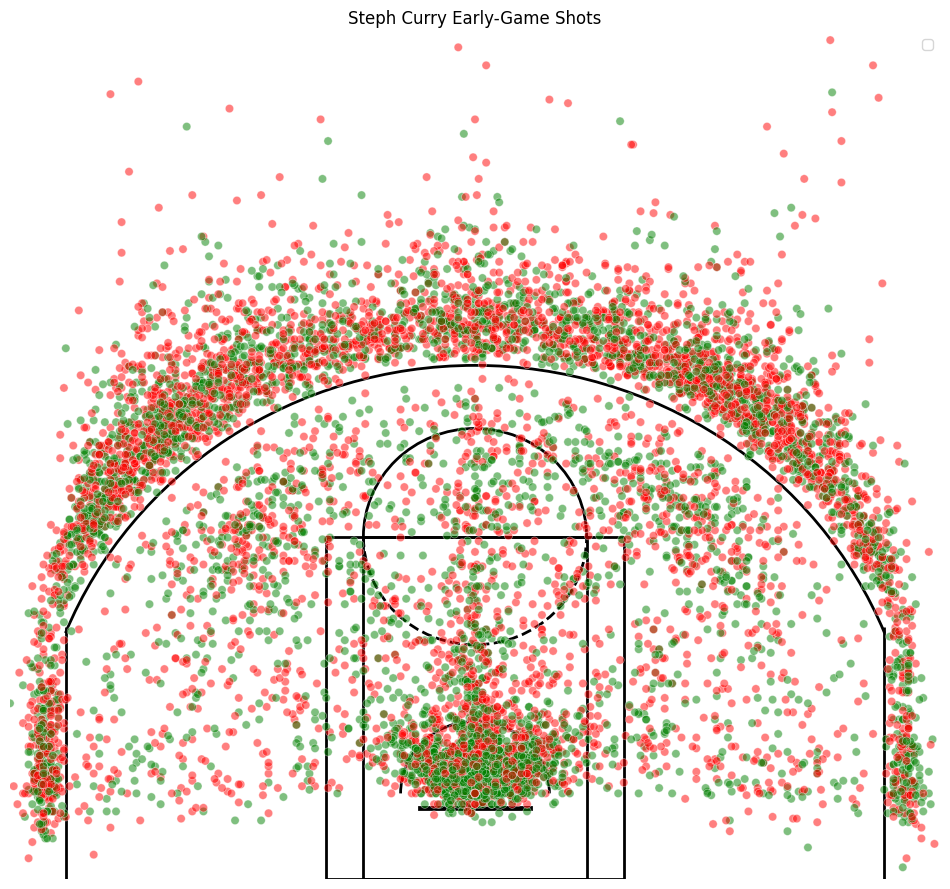

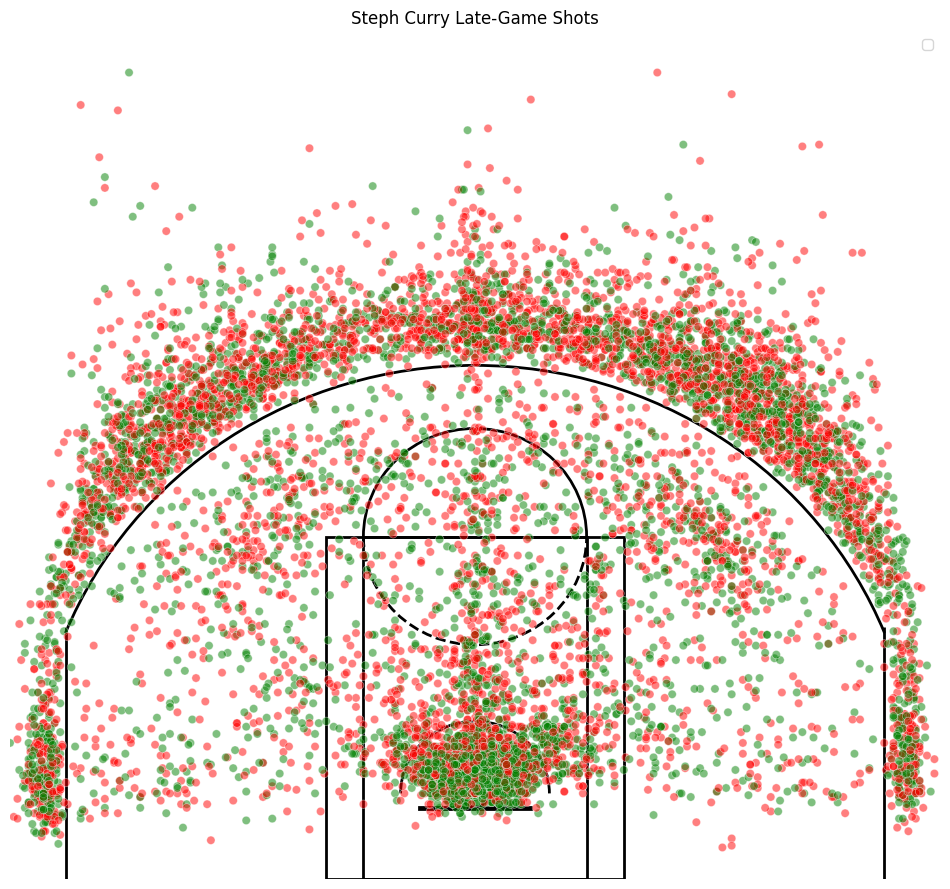

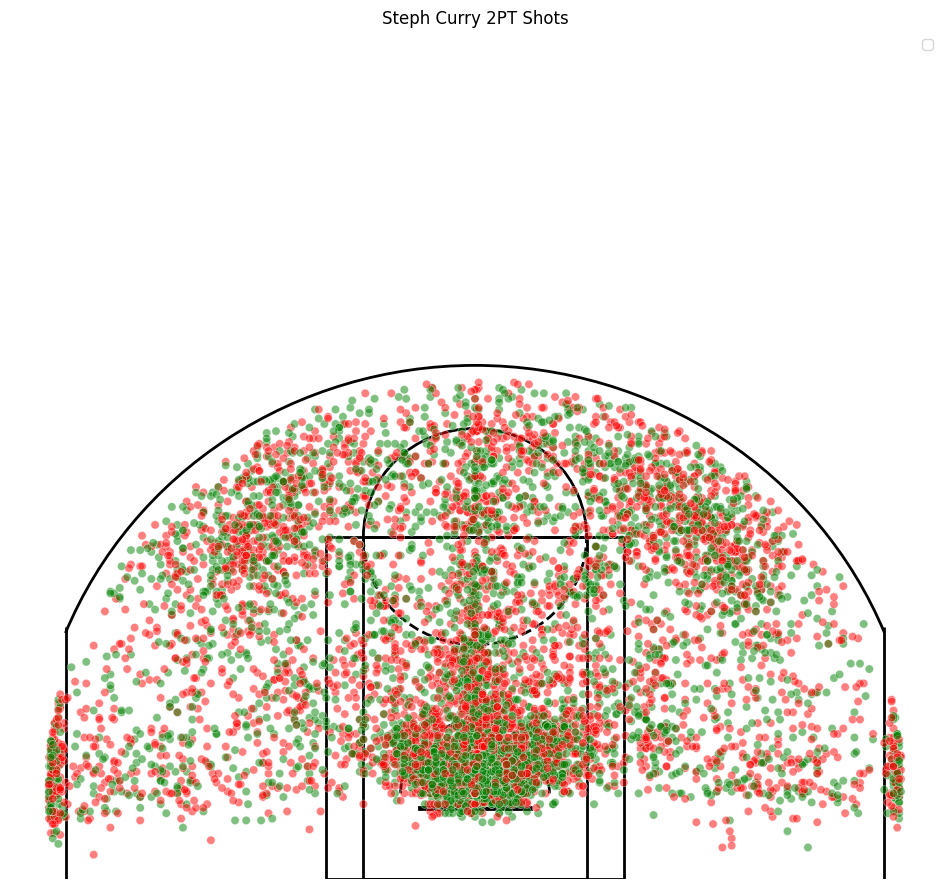

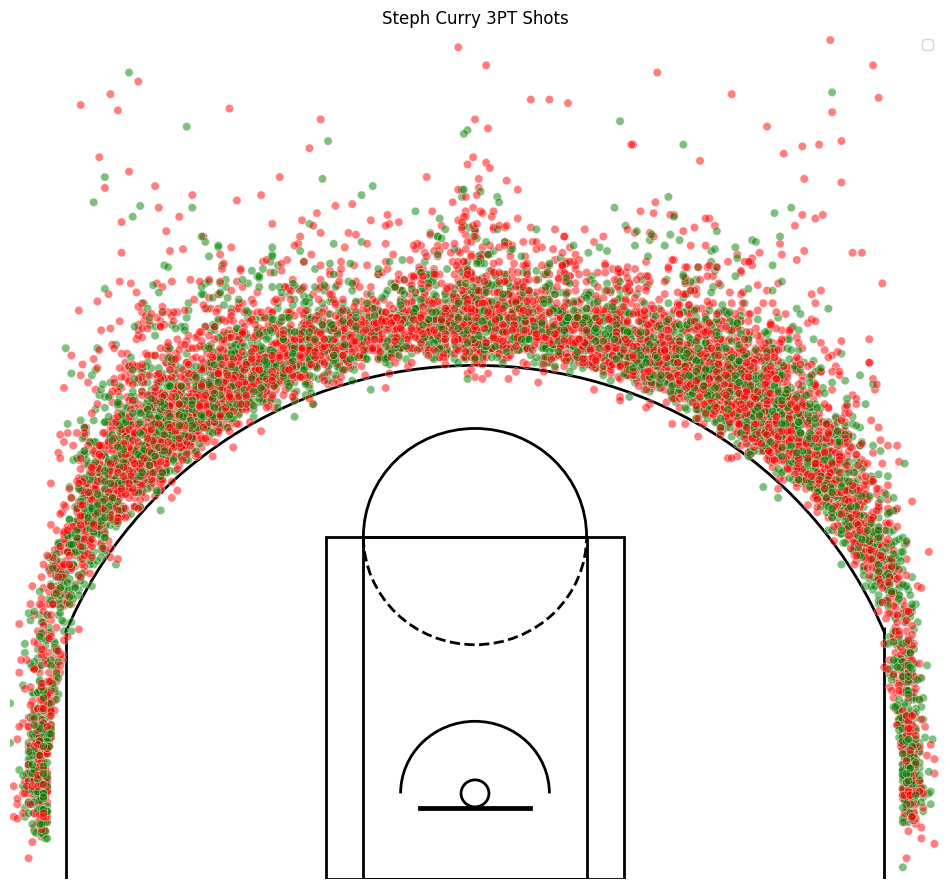

In [9]:
import matplotlib.pyplot as plt
from court import draw_half_court
import seaborn as sns

def plot_segment(df_seg, title):
    plt.figure(figsize=(12,11))
    ax = plt.gca(); draw_half_court(ax)
    sns.scatterplot(
        data=df_seg, x='loc_x', y='loc_y',
        hue='shot_made_flag',
        palette={1:'green',0:'red'},
        alpha=0.5, ax=ax
    )
    plt.title(title); plt.legend([],[]); plt.show()

# Early vs Late
for seg in ['early','late']:
    plot_segment(df[df.game_segment==seg],
                 f"Steph Curry {seg.title()}-Game Shots")

# 2PT vs 3PT
plot_segment(df[df.is_3pt==False], "Steph Curry 2PT Shots")
plot_segment(df[df.is_3pt==True],  "Steph Curry 3PT Shots")


### exporting the model 🥒

In [10]:
import pickle, os

os.makedirs('../models', exist_ok=True)
pickle.dump(rf, open('../models/rf_curry.pkl','wb'))